In [ ]:
packages <- c("cowplot", "digest", "infer", "repr", "tidyverse", "dplyr")
install.packages(packages)
invisible(lapply(packages, library, character.only = TRUE))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘patchwork’


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



#Effect of Beta Blocker Use on Peak Exercise-Induced Heart Rate

##Introduction

Cardiovascular disease, disorder of the heart and blood vessels, is the leading cause of death worldwide (1,2). Exercise can be dangerous for those with heart conditions. Thus, numerous drugs, such as beta blockers, have been developed to decrease stress on the heart during daily activities.

The sympathetic nervous system, also known as the “fight or flight” system, is stimulated by internal or external stressors, e.g. exercise. When the sympathetic nervous system is activated, blood pressure, and heart rate increase dramatically (4). Beta blockers have been proposed to dampen the exercise-induced sympathetic response, therefore, reducing excess heart stimulation. This effect is demonstrated in cell and animal studies (5) as well as randomized controlled clinical trials (6), which typically enrol from healthy and homogenous patient populations for a clean, experimental environment (7).

However, real-world effectiveness of beta blockers remains understudied, due to concomitant diseases and heterogeneity of the patient population (7). Thus, our study aims to evaluate the effectiveness of beta blockers in a heterogeneous real-world patient dataset through our research question: Do patients on beta blockers have a reduced peak exercise-induced heart rate compared to patients who are not?

The dataset contains 303 consecutive patients referred for coronary artery imaging at Cleveland Clinic using standard exercise protocols from May 1981 to September 1984, where no patients had history of heart attacks, heart valve issues, or heart muscle disease, but may have had complaints of chest pain (8,9). Data collected includes 76 variables, for example, age, sex, chest pain type, peak exercise blood pressure, peak exercise heart rate, etc. (8,9).

The location parameter for the response variable (peak exercise-induced heart rate) will be the mean, and our scale parameter will be the standard deviation. We do this since later on, we will create a confidence interval and hypothesis test for difference in means in a final report.

## Methods and Results

Each data point is a set of rows, containing 76 individual values all together, with -9 representing a missing value. Some rows on the bottom of the file do not follow the aforementioned formatting and were removed. Detrano et al., 1989 (8) describes that the dataset should have 303 patients. As our cleaned up data only includes 280 patients, it can be inferred that rows on the bottom of the file contain corrupted data for the remaining 23 patients.

The data was extracted by first checking if the 5th row had the string "name" in the 5th column.
This is the delimiter for every data point, but the data point was broken into multiple rows.
Then, the maximum heart rate and beta blockers category is found in the 4th and 5th rows, both in the first column.

Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“embedded nul(s) found in input”


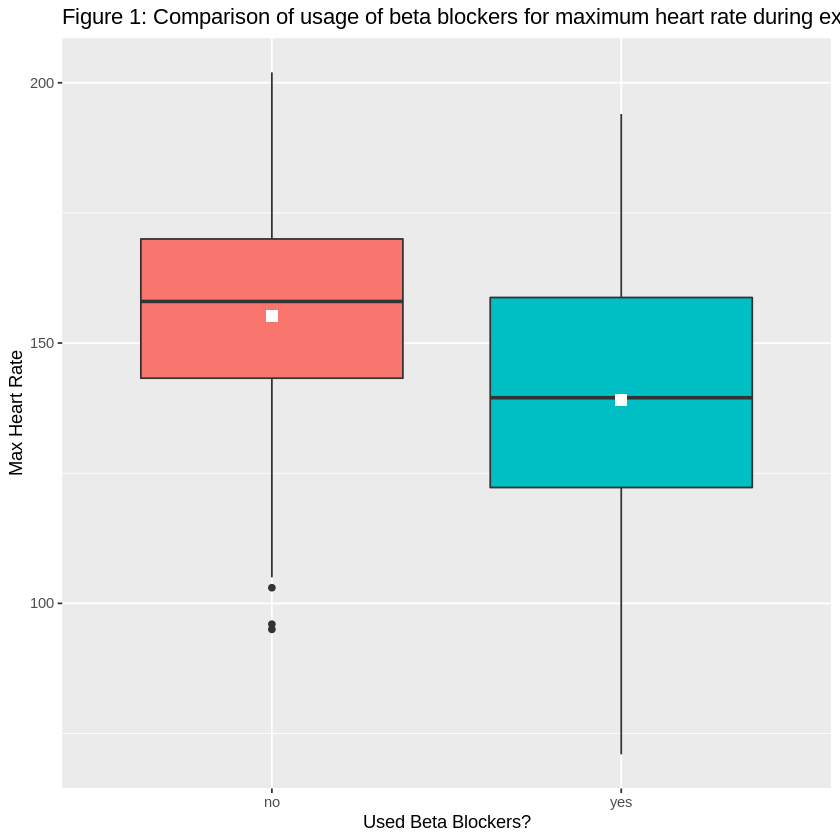

In [ ]:
cleveland <- read.delim('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/cleveland.data', header = FALSE, sep = " ")

cleaned_cleveland <- tibble(
  beta_blockers = factor(),
  max_heart_rate = numeric()
)

for(i in seq(10, nrow(cleveland), 10)) {
  if (slice(cleveland, i)[5] != "name") break
  else if (slice(cleveland, i-6)[[1]] != -9) {
    cleaned_cleveland <- cleaned_cleveland %>%
      add_row(beta_blockers = as.factor(c("no", "yes")[as.numeric(slice(cleveland, i-6)[[1]])+1]),
              max_heart_rate = as.numeric(slice(cleveland, i-5)[[1]]))
  }
}

cleaned_cleveland %>%
    ggplot(aes(x = beta_blockers, y = max_heart_rate, fill = beta_blockers)) +
    geom_boxplot() +
    guides(fill = "none") +
    stat_summary(fun = mean, geom="point", shape=15, size=3, show.legend=FALSE, color = "white") +
    labs(x = "Used Beta Blockers?", color = "Used Beta Blockers?", y = "Max Heart Rate", title = "Figure 1: Comparison of usage of beta blockers for maximum heart rate during exercise")

The mean, median, standard deviation, interquartile range, minimum and maximum of the data were calculated using in-built functions. This plot contrasts the distribution of the two groups, where there the median of the beta blocker group is lower than that of the group which did not take beta blockers. The mean (white square on boxplot) and median are visually similar for the group that took beta blockers, but different for the group that did not take beta blockers. This is likely due to outliers in the no beta blocker group which reduce the mean.

In [ ]:
cleveland_overview <- cleaned_cleveland %>% 
  group_by(beta_blockers) %>% 
  summarize(mean = mean(max_heart_rate),
            median = median(max_heart_rate),
            sd = sd(max_heart_rate),
            iqr = IQR(max_heart_rate),
            min = min(max_heart_rate),
            max = max(max_heart_rate),
            n = n())
cleveland_overview

beta_blockers,mean,median,sd,iqr,min,max,n
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
no,155.2527,158.0,20.38774,26.75,95,202,186
yes,139.1170,139.5,24.08045,36.50,71,194,94


This table summarizes similar data to  the boxplot, but also shows the differences in sample size between the two groups.

While these estimates demonstrate that a difference exists between the mean maximum heart rate of people that were administrated beta blockers and those who were not, this is not enough evidence to demonstrate that they are different. 

Confidence intervals must be calculated to create a range for possible true max heart rates of each group. The sample size for each group is is "large enough" (30-50) to apply the Central limit theorem, allowing us to perform a hypothesis test on the difference between means.

### Performance of t-test for difference in means at a 1% significance level

mu_yes = mean heartrate during exercise for individuals who were administered beta blockers.

mu_no = mean heartrate during exercise for individuals who were not administered beta blockers.

```
H_0: mu_no = mu_yes
H_A: mu_no > mu_yes
```

We calculated the mean difference by taking the mean of people how did use beta blockers and subtracting it by the mean of those who did not.
We also calculated the standard error, t-statistic and p-value below.

In [ ]:
cleveland_summary <-
  cleaned_cleveland %>%
  group_by(beta_blockers) %>%
  summarise(n = n(), mean = mean(max_heart_rate), sd = sd(max_heart_rate)) %>%
  pivot_wider(names_from = beta_blockers, values_from = c(n, mean, sd)) %>%
  mutate(mean_diff = mean_yes - mean_no,
         std_error = sqrt(sd_no^2 / n_no + sd_yes^2 / n_yes),
         tstat = mean_diff / std_error,
         df = std_error^4 / ((sd_no^2 / n_no)^2 / (n_no - 1) + (sd_yes^2 / n_yes)^2 / (n_yes - 1)),
         pval = pt(tstat, df))
cleveland_summary

n_no,n_yes,mean_no,mean_yes,sd_no,sd_yes,mean_diff,std_error,tstat,df,pval
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
186,94,155.2527,139.117,20.38774,24.08045,-16.13567,2.898886,-5.566162,161.9046,5.295846e-08


Since we only have the sample standard deviation and sample mean difference, we plotted a t-distribution below rather than a standard normal distribution.
The graph was constructed by using the t-statistic and the degrees of freedom from the calculations above.
In this graph, we plot the t-statistic in a dashed blue line, p-value in the red area below the graph, and a 95% CI in the blue rectangle.

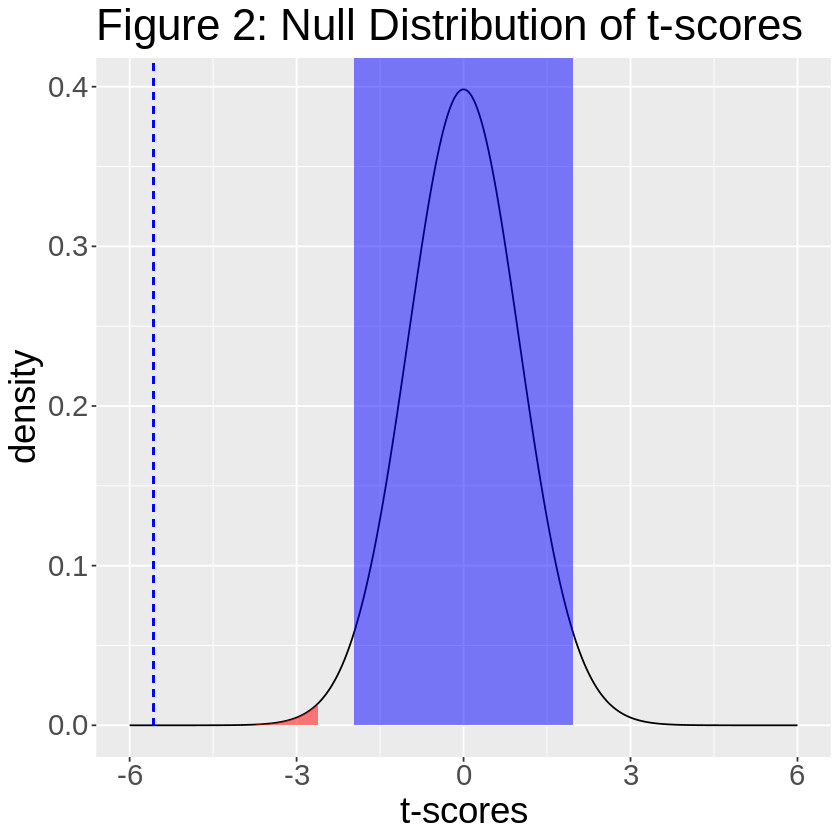

In [ ]:
cleveland_t_score <-
    tibble(t = seq(-6, 6, 0.01), density = dt(t, df = cleveland_summary$df)) %>%
    ggplot() + geom_line(aes(t, density)) +
    geom_segment(aes(x = cleveland_summary$tstat,
                    y = 0,
                    xend = cleveland_summary$tstat,
                    yend = Inf),
                colour = "blue", linetype = "dashed") +
    geom_ribbon(. %>% filter(t < qt(0.005, cleveland_summary$df)),
                mapping = aes(x = t, ymax = density, ymin = 0), alpha = 0.5, fill = "red") +
    geom_ribbon(. %>% filter(qt(0.025, cleveland_summary$df) < t & t < qt(0.975, cleveland_summary$df)),
                mapping = aes(x = t, ymax = Inf, ymin = 0), alpha = 0.5, fill = "blue") +
    theme(text = element_text(size = 22)) +
    xlab("t-scores") +
    ggtitle("Figure 2: Null Distribution of t-scores")
cleveland_t_score

Given that the p-value is less than our significance level of 0.01, we reject the null hypothesis that there is no difference in the peak heart rates of individuals that took beta blockers, and those that have not.

Because we rejected the null hypothesis, we are at risk of commiting type 1 error. This is would be the case if beta blockers do not actually reduce your average heart rate during exercise even though we found evidance that they do. It could be very bad if doctors were to prescribe beta blockers to reduce peak heart rate during exercise, if they don't actually do that. Since our alpha level is 0.01, there is only a 1% chance that we commited type 1 error.

A simulation with 2000 replicates was also performed to create a 95% CI from bootstrapping using the infer workflow.
This time, the dashed blue line is the mean difference, and the 95% CI is the cyan rectangle.

Warning message:
“The statistic is based on a difference or ratio; by default, for difference-based statistics, the explanatory variable is subtracted in the order "no" - "yes", or divided in the order "no" / "yes" for ratio-based statistics. To specify this order yourself, supply `order = c("no", "yes")` to the calculate() function.”


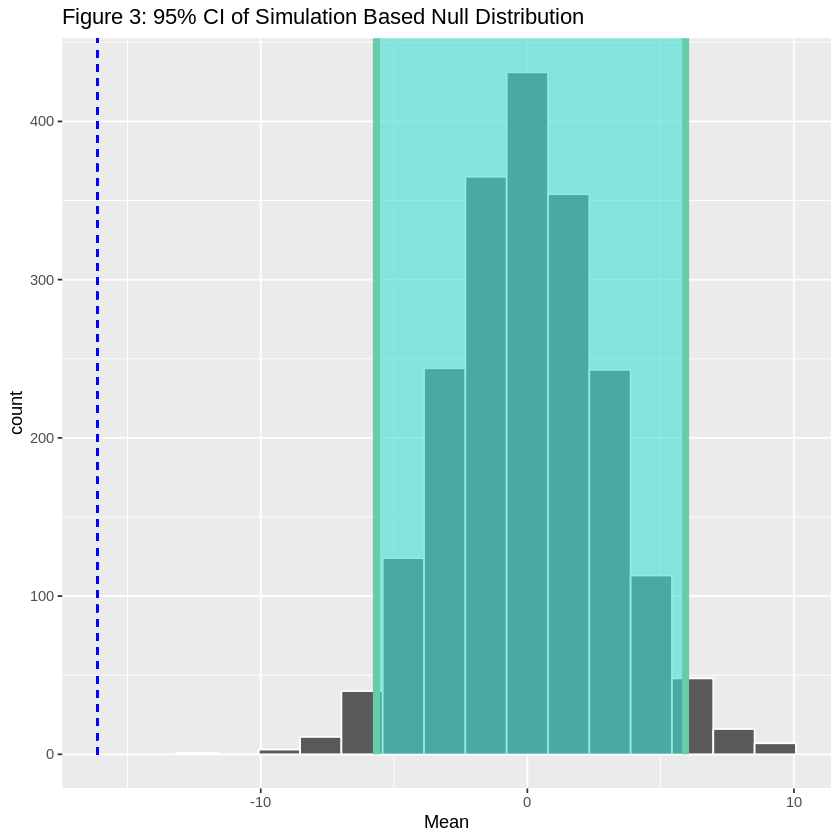

In [ ]:
bs_cleveland <-
  cleaned_cleveland %>%
  specify(formula = max_heart_rate ~ beta_blockers) %>%
  hypothesise(null = "independence") %>%
  generate(type = "permute", reps = 2000) %>%
  calculate(stat = "diff in means")

bs_cleveland_dist <-
  bs_cleveland %>%
  visualize() +
  shade_ci(bs_cleveland %>%
           get_ci()) +
  geom_segment(aes(x = cleveland_summary$mean_diff,
                   y = 0,
                   xend = cleveland_summary$mean_diff,
                   yend = Inf),
                   colour = "blue", linetype = "dashed") +
  xlab("Mean") +
  ggtitle("Figure 3: 95% CI of Simulation Based Null Distribution")
bs_cleveland_dist

Comparing figures 2 and 3, we see that the position of the 95% CI and the dotted blue line representing the t-statistic in figure 2 and mean difference in figure 3 are quite similar, because we have a high degree of freedom for the asymptotic graph, which makes it closer to a normal distribution.
In this case, either graph is trustworthy for plotting the confidence interval.
On the other hand, the p-value is efficiently visualized in an asymptotic graph rather than a histogram.

---

##Discussion



In this report, we aimed to determine whether individuals taking beta blockers during a standard exercise procedure had a lower heart rate than individuals who did not take beta blockers.
Using a t-test, we were able to reject the null hypothesis that the two groups had the same heart rate (p < 0.01) at the 1% significance level.
This also means that we have a 1% chance of a committing a type I error.
Through bootstrapping, we were able to find that the mean difference is outside of the 95% confidence interval, which agrees with our t-test, since the t-statistic is the mean difference standardized.
Visually, it also shows us that the p-value is very low since the mean difference is far away from zero, the null hypothesis.
The mean difference says that the maximum heart rate of those who used beta blockers are lower than those who did not, which is what we expected to find.

These findings align with the biological mechanism of action of beta blockers, which consist of the dampening of the sympathetic nervous system during exercise (3-6).
This is significant as this study was performed on a heterogeneous patient population, where some patients noted cardiac pain during the exercise protocol, while others did not (8).
In addition, some patients were also on concomitant medications during this study including digoxin, calcium channel blockers, and nifedipine, which all impact the functioning of the cardiovascular system.
This could indicate that beta blockers are able to lower heart rate significantly even with the activity of other drugs with similar mechanisms of action.

However, the heterogeniety and use of concomitant medications also present a limitation to this study - as the two groups were not matched, the significant difference found between the maximal exercise induced heart rates in the two groups could also be attributed to differences in sex, age, or medication use. To strengthen the findings from this report, it important that the demographic and clinical variables are compared between the two groups to unveil potential confounders to the relationship between exercise-induced heart rate and beta blocker use.

Overall, this report was able to explore the relationship between beta blocker use and exercise-induced heart rate. Further studies should be performed to explore potential confounding variables and better understand interactions between beta blockers and other medications.

## References

1. Mathers, C. D., A. Lopez, C. Stein, D. Ma Fat, C. Rao, M. Inoue, and others. 2001. "Deaths and Disease Burden by Cause: Global Burden of Disease Estimates for 2001 by World Bank Country Groups." *In Disease Control Priorities Project Working Paper 18*. Bethesda, MD.
2. Gaziano, T., Reddy, K. S., Paccaud, F., Horton, S., & Chaturvedi, V. (2006). Cardiovascular disease. *Disease Control Priorities in Developing Countries. 2nd edition.*
3. Krum, H. (1999). Sympathetic activation and the role of beta‐blockers in chronic heart failure. *Australian and New Zealand journal of medicine, 29(3)*, 418-427.
4. Sinski, M., Lewandowski, J., Abramczyk, P., Narkiewicz, K., & Gaciong, Z. (2006). Why study sympathetic nervous system. *J Physiol Pharmacol*, 57(Suppl 11), 79-92.
5. Oliver, E., Mayor Jr, F., & D’Ocon, P. (2019). Beta-blockers: historical perspective and mechanisms of action. *Revista Española de Cardiología (English Edition)*, 72(10), 853-862.
6. Kotecha, D., Flather, M. D., Altman, D. G., Holmes, J., Rosano, G., Wikstrand, J., ... & Beta-Blockers in Heart Failure Collaborative Group. (2017). Heart rate and rhythm and the benefit of beta-blockers in patients with heart failure. *Journal of the American College of Cardiology*, 69(24), 2885-2896.
7. Saturni, S., Bellini, F., Braido, F., Paggiaro, P., Sanduzzi, A., Scichilone, N., ... & Papi, A. (2014). Randomized controlled trials and real life studies. Approaches and methodologies: a clinical point of view. *Pulmonary pharmacology & therapeutics*, 27(2), 129-138.
8. Detrano, R., Janosi, A., Steinbrunn, W., Pfisterer, M., Schmid, J. J., Sandhu, S., ... & Froelicher, V. (1989). International application of a new probability algorithm for the diagnosis of coronary artery disease. *The American journal of cardiology*, 64(5), 304-310.
9.  Janosi, A., Steinbrunn, W., Pfisterer, M., Detrano, R., & Aha, D. (1988, July 1).*Heart Disease Data Set*. UCI machine Learning REPOSITORY: Heart disease data set. https://archive.ics.uci.edu/ml/datasets/Heart+Disease.